In this notebook we use logistic regression to explore how the outcome of the first n rounds can predict the outcome of a game and whether some rounds are more important relative to others.  We reuse code used elsewhere so there may be some redundant code, especially pertaining to economy information.  


In [2]:
#Import the modules that will be used

import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [14]:
#We use "eco_rounds.csv" to obtain the outcome of each round.  We use 1,-1 to encode win,loss respectively of a round. 

eco_rounds = pd.read_csv("../data/vct_2023/matches/eco_rounds.csv")
eco_rounds["Outcome"] = eco_rounds["Outcome"].apply(lambda x: 1 if x == "Win" else -1)

eco_rounds["Loadout Value"] = eco_rounds["Loadout Value"].apply(lambda x: int(x.replace(".","").replace("k","00")))
eco_rounds["Remaining Credits"] = eco_rounds["Remaining Credits"].apply(lambda x: int(x.replace(".","").replace("k","00")))
eco_rounds.head()

,Tournament,Stage,Match Type,Match Name,Map,Round Number,Team,Loadout Value,Remaining Credits,Type,Outcome
0,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Fracture,1,Team Liquid,3600,400,Eco: 0-5k,1
1,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Fracture,1,Natus Vincere,3500,300,Eco: 0-5k,-1
2,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Fracture,2,Team Liquid,15600,4100,Semi-buy: 10-20k,1
3,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Fracture,2,Natus Vincere,4200,6400,Eco: 0-5k,-1
4,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Fracture,3,Team Liquid,13300,14800,Semi-buy: 10-20k,1


In [22]:
#Combine the round-level data from eco_rounds into a single row to obtain game-level data

maps_scores = pd.read_csv("../data/vct_2023/matches/maps_scores.csv")
team_ab_2023 = maps_scores[["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team A", "Team B", "Team A Score", "Team B Score"]]
keys = ['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map','Team']

#It can be checked that the maximum number of rounds played in a single game in our data is 40
for i in range(40):
    team_ab_2023 =\
    pd.merge(
        team_ab_2023.rename(columns={"Team A":"Team"})\
        ,eco_rounds[eco_rounds["Round Number"] == i+1].drop(columns="Round Number")\
        ,on=keys
        ,how='left'
    )\
    .rename(columns={"Loadout Value":f"R{i+1}_A_lo", "Remaining Credits":f"R{i+1}_A_rc", "Type":f"R{i+1}_A_et", "Outcome":f"R{i+1}_A_win"})\
    .rename(columns={"Team":"Team A", "Team B":"Team"})\
    .set_index(['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map','Team'])\
    .join(eco_rounds[eco_rounds["Round Number"] == i+1].drop(columns="Round Number")\
        .set_index(['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map','Team'])\
    )\
    .reset_index()\
    .rename(columns={"Loadout Value":f"R{i+1}_B_lo", "Remaining Credits":f"R{i+1}_B_rc", "Type":f"R{i+1}_B_et", "Outcome":f"R{i+1}_B_win"})\
    .rename(columns={"Team":"Team B"})\

team_ab_2023["Team_A_win"] = (team_ab_2023["Team A Score"] - team_ab_2023["Team B Score"]) > 0
team_ab_2023["Team_B_win"] = (team_ab_2023["Team B Score"] - team_ab_2023["Team A Score"]) > 0

In [23]:
team_ab_2023

,Tournament,Stage,Match Type,Match Name,Map,Team B,Team A,Team A Score,Team B Score,R1_A_lo,...,R40_A_lo,R40_A_rc,R40_A_et,R40_A_win,R40_B_lo,R40_B_rc,R40_B_et,R40_B_win,Team_A_win,Team_B_win
0,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Fracture,Natus Vincere,Team Liquid,11,13,3600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
1,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Bind,Natus Vincere,Team Liquid,15,17,4000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Lotus,LOUD,DRX,13,15,4100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
3,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Split,LOUD,DRX,13,6,3500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
4,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Ascent,LOUD,DRX,13,8,3600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,Champions Tour 2023: Lock-In Sao Paulo,Playoffs,Grand Final,LOUD vs FNATIC,Ascent,FNATIC,LOUD,8,13,4200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
826,Champions Tour 2023: Lock-In Sao Paulo,Playoffs,Grand Final,LOUD vs FNATIC,Fracture,FNATIC,LOUD,7,13,3600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
827,Champions Tour 2023: Lock-In Sao Paulo,Playoffs,Grand Final,LOUD vs FNATIC,Split,FNATIC,LOUD,13,9,4100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
828,Champions Tour 2023: Lock-In Sao Paulo,Playoffs,Grand Final,LOUD vs FNATIC,Lotus,FNATIC,LOUD,13,8,4200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False


In [36]:
#There are some rows with entirely missing information
team_ab_2023[team_ab_2023.R1_A_win.isna()==True].describe()

,Team A Score,Team B Score,R1_A_lo,R1_A_rc,R1_A_win,R1_B_lo,R1_B_rc,R1_B_win,R2_A_lo,R2_A_rc,...,R39_A_win,R39_B_lo,R39_B_rc,R39_B_win,R40_A_lo,R40_A_rc,R40_A_win,R40_B_lo,R40_B_rc,R40_B_win
count,59.000000,59.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,10.474576,10.559322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3.710916,3.505027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,9.000000,7.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,13.000000,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,13.000000,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,18.000000,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#We drop these rows for now and fill in 0 for rounds numbers that are not played - a game ends when a team wins 13 rounds by at least a margin of 2, so if a team wins the first 13 rounds, rounds 14-40 outcomes will be encoded as 0
j=team_ab_2023[team_ab_2023.R1_A_win.isna()==False]
j['total_rounds'] = j['Team A Score'] + j['Team B Score']
j=j.fillna(0)

C:\Users\swamp\AppData\Local\Temp\ipykernel_14932\265682310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j['total_rounds'] = j['Team A Score'] + j['Team B Score']


In [38]:
j.head()

,Tournament,Stage,Match Type,Match Name,Map,Team B,Team A,Team A Score,Team B Score,R1_A_lo,...,R40_A_rc,R40_A_et,R40_A_win,R40_B_lo,R40_B_rc,R40_B_et,R40_B_win,Team_A_win,Team_B_win,total_rounds
0,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Fracture,Natus Vincere,Team Liquid,11,13,3600.0,...,0.0,0,0.0,0.0,0.0,0,0.0,False,True,24
1,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Bind,Natus Vincere,Team Liquid,15,17,4000.0,...,0.0,0,0.0,0.0,0.0,0,0.0,False,True,32
2,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Lotus,LOUD,DRX,13,15,4100.0,...,0.0,0,0.0,0.0,0.0,0,0.0,False,True,28
3,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Split,LOUD,DRX,13,6,3500.0,...,0.0,0,0.0,0.0,0.0,0,0.0,True,False,19
4,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Ascent,LOUD,DRX,13,8,3600.0,...,0.0,0,0.0,0.0,0.0,0,0.0,True,False,21


mean of true values: 0.5161290322580645
mean of predicted values: 0.5483870967741935
accuracy: 0.7225806451612903
coefficients: [[0.65502467 0.31070051 0.55317259 0.37512548 0.52297652 0.24448591
  0.2568048  0.50339847 0.33967035 0.3916013  0.49505805 0.36890145
  0.84928514]]


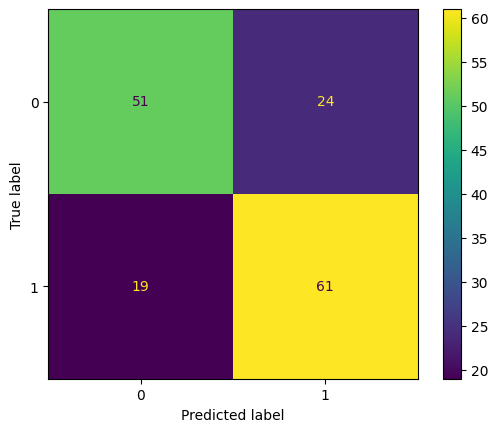

In [40]:
#Logistic regression with the outcomes of rounds 1 to 13 as features and the game outcome as target.
pred_cols = [f"R{i+1}_A_win" for i in range(13)]

X = j[pred_cols]
y = j['Team_A_win']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, stratify=y, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
train_pred=model.predict(X_train)
acc = accuracy_score(y_test,y_pred)
print("mean of true values:",y_test.mean())
print("mean of predicted values:",y_pred.mean())
print("accuracy:",acc)
print("coefficients:",model.coef_)

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

mean of true values: 0.4838709677419355
mean of predicted values: 0.49032258064516127
accuracy: 0.7483870967741936
coefficients: [[0.6067115  0.27467237 0.44676233 0.28795673 0.68064333 0.21004137
  0.32774485 0.47936044 0.28748985 0.31009781 0.42632892 0.42394978
  0.89337039]]


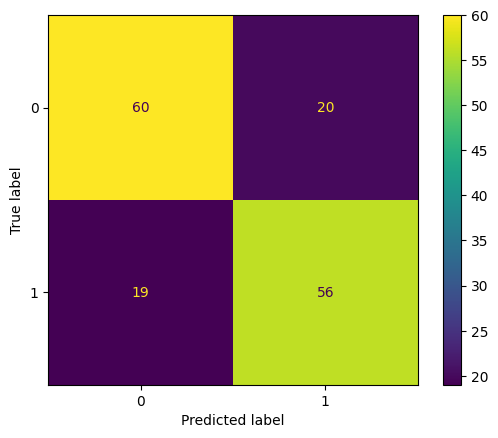

In [41]:
#Same as above but on team B

pred_cols = [f"R{i+1}_B_win" for i in range(13)]

X = j[pred_cols]
y = j['Team_B_win']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, stratify=y, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
train_pred=model.predict(X_train)
acc = accuracy_score(y_test,y_pred)
print("mean of true values:",y_test.mean())
print("mean of predicted values:",y_pred.mean())
print("accuracy:",acc)
print("coefficients:",model.coef_)

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [45]:
#The results from Team A and Team B are similar so we will just focus on predicting Team A game wins.  Run a prediction where we vary the games seen from the first round to all rounds.
analysis_dictionary = {\
        "rounds_seen":[],
        "mean_y_train":[],
        "mean_y_test":[],
        "mean_train_pred":[],
        "mean_test_pred":[],
        "train_acc":[],
        "test_acc" :[],
        "coefficients":[]
        }\

analysis_df = pd.DataFrame()

for i in range(1,41):
    pred_cols = [f"R{j}_A_win" for j in range(1,i+1)]
    
    X = j[pred_cols]
    y = j['Team_A_win']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, stratify=y, random_state=42)

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_pred=model.predict(X_train)


    
    analysis_dictionary["rounds_seen"].append(i)
    analysis_dictionary["mean_y_train"].append(np.mean(y_train))
    analysis_dictionary["mean_y_test"].append(np.mean(y_test))
    analysis_dictionary["mean_train_pred"].append(np.mean(train_pred))
    analysis_dictionary["mean_test_pred"].append(np.mean(y_pred))
    analysis_dictionary["train_acc"].append(accuracy_score(y_train, train_pred))
    analysis_dictionary["test_acc"].append(accuracy_score(y_test, y_pred))
    analysis_dictionary["coefficients"].append(np.round(model.coef_[0],2))


for feature_name, lst in analysis_dictionary.items():
    analysis_df[feature_name] = lst

pd.set_option("display.max_colwidth",100)

analysis_df

,rounds_seen,mean_y_train,mean_y_test,mean_train_pred,mean_test_pred,train_acc,test_acc,coefficients
0,1,0.512987,0.516129,0.483766,0.548387,0.629870,0.619355,[0.53]
1,2,0.512987,0.516129,0.469156,0.522581,0.657468,0.593548,"[0.1, 0.58]"
2,3,0.512987,0.516129,0.472403,0.529032,0.663961,0.600000,"[0.29, 0.5, 0.48]"
3,4,0.512987,0.516129,0.496753,0.522581,0.649351,0.567742,"[0.24, 0.48, 0.41, 0.42]"
4,5,0.512987,0.516129,0.514610,0.516129,0.670455,0.638710,"[0.34, 0.43, 0.42, 0.34, 0.5]"
5,6,0.512987,0.516129,0.521104,0.529032,0.676948,0.638710,"[0.3, 0.47, 0.43, 0.35, 0.45, 0.34]"
6,7,0.512987,0.516129,0.524351,0.522581,0.706169,0.683871,"[0.33, 0.42, 0.43, 0.32, 0.46, 0.28, 0.28]"
7,8,0.512987,0.516129,0.517857,0.509677,0.719156,0.670968,"[0.42, 0.37, 0.43, 0.32, 0.46, 0.26, 0.24, 0.5]"
8,9,0.512987,0.516129,0.537338,0.522581,0.725649,0.670968,"[0.39, 0.39, 0.42, 0.31, 0.46, 0.23, 0.24, 0.45, 0.36]"
9,10,0.512987,0.516129,0.524351,0.535484,0.764610,0.709677,"[0.41, 0.38, 0.42, 0.29, 0.48, 0.24, 0.23, 0.45, 0.3, 0.4]"


In [47]:
#We focus on the first 13 rounds since these are guaranteed to be played, whereas results may be skewed for higher round numbers since they aren't played in every game.
k = analysis_df[['rounds_seen', 'train_acc', 'test_acc', 'coefficients']].iloc[range(13)]
k.round(2)

,rounds_seen,train_acc,test_acc,coefficients
0,1,0.63,0.62,[0.53]
1,2,0.66,0.59,"[0.1, 0.58]"
2,3,0.66,0.60,"[0.29, 0.5, 0.48]"
3,4,0.65,0.57,"[0.24, 0.48, 0.41, 0.42]"
4,5,0.67,0.64,"[0.34, 0.43, 0.42, 0.34, 0.5]"
5,6,0.68,0.64,"[0.3, 0.47, 0.43, 0.35, 0.45, 0.34]"
6,7,0.71,0.68,"[0.33, 0.42, 0.43, 0.32, 0.46, 0.28, 0.28]"
7,8,0.72,0.67,"[0.42, 0.37, 0.43, 0.32, 0.46, 0.26, 0.24, 0.5]"
8,9,0.73,0.67,"[0.39, 0.39, 0.42, 0.31, 0.46, 0.23, 0.24, 0.45, 0.36]"
9,10,0.76,0.71,"[0.41, 0.38, 0.42, 0.29, 0.48, 0.24, 0.23, 0.45, 0.3, 0.4]"


In [51]:
#We vary the random state of the train/test split and obtain the statistics of the coefficients given by logistic regression
dict = {}

pred_cols = [f"R{i+1}_A_win" for i in range(13)]
y = j['Team_A_win']

X = j[pred_cols]

for i in range(300):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, stratify=y, random_state=i)

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    dict[i] = model.coef_[0]



coeffs = pd.DataFrame(dict).transpose()

coeffs = coeffs.rename(columns = {i:i+1 for i in range(13)})
l = coeffs.describe()[range(1,14)].transpose()
l

,count,mean,std,min,25%,50%,75%,max
1,300.0,0.624359,0.075679,0.388952,0.566091,0.624999,0.669845,0.833361
2,300.0,0.257531,0.069526,0.049224,0.211582,0.251783,0.305430,0.483964
3,300.0,0.457020,0.054221,0.317021,0.418207,0.455932,0.492600,0.612383
4,300.0,0.305201,0.048592,0.171895,0.273055,0.302067,0.338457,0.439650
5,300.0,0.588235,0.051596,0.436209,0.551020,0.587137,0.625195,0.732438
6,300.0,0.264930,0.050434,0.115426,0.234060,0.263758,0.298337,0.388069
7,300.0,0.335068,0.045972,0.217688,0.303305,0.335196,0.363365,0.485803
8,300.0,0.445878,0.056031,0.266449,0.405616,0.444082,0.482158,0.608288
9,300.0,0.317603,0.045949,0.164389,0.286837,0.317594,0.347960,0.472573
10,300.0,0.399443,0.050237,0.272319,0.361837,0.399987,0.437453,0.515687


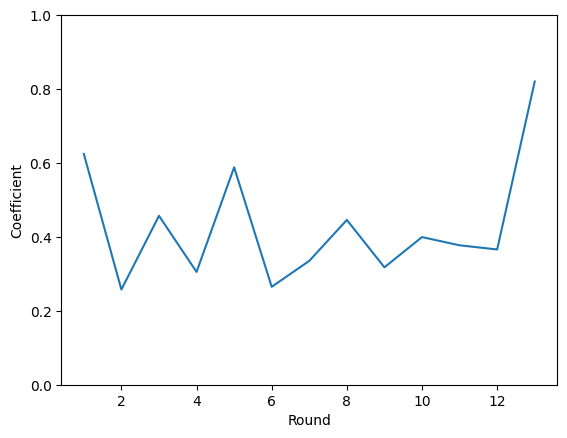

In [53]:
plt.plot(l.index,l['mean'])
plt.xlabel('Round')
plt.ylabel('Coefficient')
plt.ylim(0,1)
plt.show()

From the above graph, rounds 1, 5, and 13 appear to be more important than rounds 2, 4, and 6.  Variation of round importance is to be expected because the rules of the in-game economy induce certain patterns - a team winning a round is likely to have a large advantage in the next round